# LAB3

## SIFT Code
Computes point correspondences between two images using sift. I have taken the sift code from NPTEL.

    Args:
        img1 (np.array): Query image
        img2 (np.array): Target image

    Returns:
        points (np.array): A 2 X num_matches X 2 array.
                           `points[0]` are keypoints in img1 and the corresponding
                            keypoints in img2 are `points[1]`

In [1]:
%%capture
import numpy as np
from scipy.linalg import null_space
import cv2

def image_size(image):
    if image.ndim == 2:
        return image.shape
    else:
        return image.shape[:-1]


def sift(img1, img2):
    """
    Computes point correspondences between two images using sift

    Args:
        img1 (np.array): Query image
        img2 (np.array): Target image

    Returns:
        points (np.array): A 2 X num_matches X 2 array.
                           `points[0]` are keypoints in img1 and the corresponding
                            keypoints in img2 are `points[1]`
    """
    sift = cv2.xfeatures2d.SIFT_create()
    #sift = cv2.SIFT_create()
    #kp = sift.detect(gimg,None)

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    correspondences = np.zeros((2, len(good_matches), 2))

    for i, match in enumerate(good_matches):
        correspondences[0, i, :] = np.flip(kp1[match.queryIdx].pt)
        correspondences[1, i, :] = np.flip(kp2[match.trainIdx].pt)

    return correspondences

## Computing Corresponding points in img1 and img3 wrt img2
  Reading the images and Computing corresponding points using sift function
              

In [2]:
import cv2 
src1=cv2.imread('img1.png',0)
src2=cv2.imread('img2.png',0)
src3=cv2.imread('img3.png',0)

#Run SIFT and obtain matching key points
corresp12 = sift(src1,src2)
corresp32 = sift(src3,src2)
correspa1 = corresp12[0]
correspa2 = corresp12[1]
correspc1 = corresp32[0]
correspc2 = corresp32[1]

## Importing Neccessary Libraries

In [3]:
#Import libraries
from pylab import *
import cv2
import random
import csv
from scipy.linalg import null_space
from sympy import *

## Bilinear Interpolation
Computes the intensity at each point of  the target image by bilinearly interpolating
    intensities in the immediate 2 X 2 neighborhood of the corresponding source point of each target point .
    
    Args:
        src (np.array): The source image
        H : Homography 
        rows= rows of the target image 
        cols= columns of the target image 
    Returns:
        Pixel intensity 

In [4]:
#Bilinear
#Rows and columns of the target as input

def bilinear_interpolation(src, H, rows, cols) :
     #Creating vector to multiply Hinv
     x1=[]
     y1=[]   
     #t= np.array([ti,tj, 1])
     #Target to source mapping  
     for xn in range(0,rows) :
         for yn in range(0,cols) :
             xy = array([xn,yn-cenx,1])
             xy_temp = np.linalg.inv(H)@ xy
            #xy_temp = xy_temp.T
             x = xy_temp[0]/xy_temp[2]
             y = xy_temp[1]/xy_temp[2]
             x1.append(x)
             y1.append(y) 
     #print(shape(x),shape(y))
     
     #xf = int(np.floor(x)) 
     #yf = int(np.floor(y))
     x2=array(x1)   
     y2=array(y1)
     xf = x2.astype(int)
     yf = y2.astype(int)
     
     #distance from pixel
     a = x2-xf
     b = y2-yf
     
     Ival = np.zeros(shape(xf))
     #print(shape(src))
     #Find intensity
     for i in range(0,len(xf)) :
          #if check[i] == False :
          if xf[i] < shape(src)[0]-1 and yf[i] < shape(src)[1]-1 and xf[i]>0 and yf[i]>0 :
               #print(yf[i])
               Ival[i] = (1-a[i])*(1-b[i])*src[xf[i]][yf[i]] + (1-a[i])*(b[i])*src[xf[i]][yf[i]+1] + (a[i])*(1-b[i])*src[xf[i]+1][yf[i]] + (a[i])*(b[i])*src[xf[i]+1][yf[i]+1]

     Ival = Ival.reshape(rows,cols)
     return Ival

## RANSAC
Computes a robust homography between the point correspondences using RANSAC
    
    Args:
        corresp1(np.array) : The refernce image points
        corresp2(np.array) : The target image corresponding points
        
    Returns:
        np.array: Robust homography

In [5]:
#RANSAC
def ransac(corresp1,corresp2) :
     fraction = 0    ## fraction: is the fraction of inliers
     n_iterations = 0  ## No of iterations to run the RANSAC 
     while(fraction <= 0.95) :      ## If the total inliers are less than 95 percent of all the remaining points
             
          #Generate 4 random numbers from the set
          length = len(corresp1)     ## Total corresponding points of the reference image 
          r = random.sample(range(0,length),4)      ## Generating 4 random index of the total no of points
          a = [corresp1[r[i]] for i in range(0,len(r))]  ## Getting the corresponding points of the index that we got 
          b = [corresp2[r[i]] for i in range(0,len(r))] 
          #Take these 4 points and find homography
            
          #Generatiing the A Matrix
          eqns = 4      # No of equations 
          A = np.zeros((int(2*eqns),9))
          #print(shape(A))
          #Loop to fill in the values
          """
            For one corresponding points (one equation) we have 2 rows of A like this
            [[x,y,1,0,0,0,-x*x',-y*x',-x']    
             [0,0,0,x,y,1,-x*y',-y*y',-y']]
          """
          ## Iterating over the four equations to get 8 rows 
          for i in range(0,eqns) :
               A[int(2*i)][0] = b[i][0]               ##x             b[i][0]=x    ## See the equations in notes
               A[int(2*i)][1] = b[i][1]               ##y             b[i][1]=y
               A[int(2*i)][2] = 1                     ##1             a[i][0]=x'
               A[int(2*i)][3] = 0                     ##0             a[i][1]=y'
               A[int(2*i)][4] = 0                     ##0
               A[int(2*i)][5] = 0                     ##0
               A[int(2*i)][6] = -b[i][0]*a[i][0]      ##-x*x'         
               A[int(2*i)][7] = -b[i][1]*a[i][0]      ##-y*x'
               A[int(2*i)][8] = -a[i][0]              ##-x'
               
               A[int(2*i)+1][0] = 0                   ##0
               A[int(2*i)+1][1] = 0                   ##0
               A[int(2*i)+1][2] = 0                   ##0
               A[int(2*i)+1][3] = b[i][0]             ##x
               A[int(2*i)+1][4] = b[i][1]             ##y
               A[int(2*i)+1][5] = 1                   ##1
               A[int(2*i)+1][6] = -b[i][0]*a[i][1]    ##-x*y'
               A[int(2*i)+1][7] = -b[i][1]*a[i][1]    ##-y*y'
               A[int(2*i)+1][8] = -a[i][1]            ##-y'

          #Find nullspace of the matrix
          h = null_space(A)
          #print(shape(h))
          #Put h in order
          H=h.reshape((3,3))

          #Check with remaining points and see fraction         ## set_A.difference(set_B) for (A - B)
          B = []     ## Array with the point of interest of the remaining points
          remaining_points = list(set(np.arange(0,length)).difference(r))   ## this is the remaining points 
          """
          [x",y",c].T = H @ [xi,yi,1].T    ## See the equation in the notes
          """
          threshold = 10        ## threshold(in pixels): margin of error
          
          ## Iterating over all the remaining points
          for i in remaining_points :
               xi = corresp2[i][0]  
               yi = corresp2[i][1]
               #X = array([xi,yi,1]).T
               [x2,y2,c]= H @ array([xi,yi,1]).T
               x3 = x2/c            
               y3 = y2/c
               # Calculting the distance b/w the point that we got and the point that we actually have 
               epsilon = np.sqrt(pow(corresp1[i][0]-x3,2) + pow(corresp1[i][1]-y3,2))  
               if epsilon < threshold :       
                    B.append(i)          ## If the distance is less then the threshold the we append that point in B
          #Check how good is the consensus set
          fraction = len(B)/len(remaining_points)  
          n_iterations = n_iterations+1
     return H,fraction,n_iterations,B     

## Homography 

Computing 
         
         H1: Homography Matrix of img1 with respect to img2
         H2: Homography Matrix of img3 with respect to img2 
         
         frac1: Percentage of total inliers wrt H1
         frac3: Percentage of total inliers wrt H3       

In [6]:
H1,frac1,n_iterations1,B1 = ransac(correspa2,correspa1)
H3,frac3,n_iterations3,B3 = ransac(correspc2,correspc1)
print(frac1,frac3)
print(H1)
print(H3)
print(n_iterations1,n_iterations3)

#Define topcorer
#print(shape(src1))
cenx = int(floor(shape(src1)[1]))

0.9935483870967742 0.9693251533742331
[[ 4.85300290e-03  4.25615425e-04 -2.42004504e-01]
 [-4.08063023e-05  5.37471838e-03 -9.70239741e-01]
 [-1.20867821e-07  2.13339716e-06  4.00550213e-03]]
[[-3.35966116e-03  3.78603860e-04 -1.32185590e-01]
 [ 1.17315748e-04 -2.56838245e-03 -9.91208453e-01]
 [ 4.54000790e-07  1.77508802e-06 -3.83818408e-03]]
2 1


## Creating Canvas 
Computing:
           
           canvas1: Canvas of img1 
           canvas2: Canvas of img2
           canvas3: Canvas of img3

In [7]:
#Create canvas
nrows = shape(src2)[0] ## Rows are same of the target image as we will have the same heigth of the image 
ncolumns = shape(src1)[1] + shape(src2)[1] + shape(src3)[1] ## Columns are added to get the total columns of our target

canvas = np.zeros((nrows,ncolumns))
count = np.zeros((nrows,ncolumns))

print(canvas.shape)
canvas1 = bilinear_interpolation(src1, H1, nrows, ncolumns)
canvas2 = bilinear_interpolation(src2, np.identity(3), nrows, ncolumns)
canvas3 = bilinear_interpolation(src3, H3, nrows, ncolumns)

(360, 1920)


## Counting how many images contribute at each pixel

In [8]:
#Finding no of intensities at each point
num = np.equal(canvas1,np.zeros(shape(canvas1)))  ## Compares the intensities of canvas one to that of same shape
num = ~num           ## giving all the true values where there is intensity 
num = num.astype(int)  ## converting the boolean into int i.e 1
count= count + num  ## getting all the counts of at each pixel point.

num = np.equal(canvas2,np.zeros(shape(canvas2)))
num = ~num
num = num.astype(int)
count = count+ num

num = np.equal(canvas3,np.zeros(shape(canvas3)))
num = ~num
num = num.astype(int)
count = count + num

## Image Plot

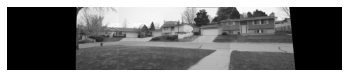

In [9]:
#Image plot
canvas = canvas1 + canvas3 + canvas2 
#final_canvas=canvas/count
#np.seterr(invalid= 'ignore')
count[count == 0] =  1
final_canvas=np.divide(canvas, count)
plt.imshow(final_canvas,cmap = "gray")
plt.axis("off")
plt.show()